## Automatic Learning of Key Phrases and Topics in Document Collections

## Part 4: Topic Modeling Analysis

### Overview

This notebook is Part 4 of 4, in a series providing a step-by-step description of how to process and analyze the contents of a large collection of text documents in an unsupervsied manner. Using Python packages and custom code examples, we have implemented the basic framework that combines key phrase learning and latent topic modeling as described in the paper entitled ["Modeling Multiword Phrases with Constrained Phrases Tree for Improved Topic Modeling of Conversational Speech"](http://people.csail.mit.edu/hazen/publications/Hazen-SLT-2012.pdf) which was originally presented in the 2012 IEEE Workshop on Spoken Language Technology.

Although the paper examines the use of the technology for analyzing human-to-human conversations, the techniques are quite general and can be applied to a wide range natural language data including news stories, legal documents, research publications, social media forum discussion, customer feedback forms, product reviews, and many more.

Part 4 of the series shows how to analysis the topical content of a collection of text docuemnts and correlate topical information against other meta-data associated with the document collection. The topic model an topic summarizations were generated in Part 3 of the series.  


### Import Relevant Python Packages

Part 4 primarily relies on the [matplotlib Python library](http://matplotlib.org) for generating graphs.

In [1]:
import numpy
import pandas 
import re
import math
from gensim import corpora, models
from operator import itemgetter
from collections import namedtuple
import matplotlib
import matplotlib.pyplot as plt
from __future__ import print_function
%matplotlib inline

### Load Text Data

In [2]:
# Load full TSV file including a column of text
docsFrame = pandas.read_csv("../Data/CongressionalDocsData.tsv", sep='\t')
#metaDataFrame = pandas.read_csv("./BillMetaData.tsv", sep='\t')

In [3]:
print(docsFrame[90:100])

                ID                                               Text  \
90  hconres103-106  Expresses the sense of Congress that the histo...   
91  hconres103-107  Honors the American Society for the Prevention...   
92  hconres103-108  Expresses the sense of Congress that: (1) each...   
93  hconres103-109  Provides for an adjournment of the House of Re...   
94  hconres103-110  Provides for an adjournment of the House of Re...   
95  hconres103-111  Supports the goals of Malaria Awareness Day, i...   
96  hconres103-112  Expresses the sense of Congress that the effec...   
97  hconres103-113  Authorizes the use of the Capitol grounds for ...   
98   hconres103-98  Expresses the sense of Congress that the Railr...   
99   hconres103-99  Prohibits ending the voluntary restraint on im...   

          Date  
90  1999-05-06  
91  2001-04-04  
92  2003-03-20  
93  2005-03-17  
94  2007-03-29  
95  2009-04-21  
96  2012-02-17  
97  2014-06-23  
98  1983-04-07  
99  1985-03-28  


### Compute the Quarter Information for Each Document

A congressional session lasts 2 years. To summarize Congressional actions taken over the duration of a session, we break each two year session into its 8 annual quarters. We can then summarize actions over the duration of these 8 quarters for each session.

In [4]:
# Break out the session number as a unique column in the documents frame 
# also create a column for the session quarter where we break dates down 
# into one of eight annual quarters per session, i.e., four quarters for 
# each of the two years in the session

quarterArray = [] 
sessionArray = []

for i in range(0,len(docsFrame)):

    dateFields = (docsFrame['Date'][i]).split('-')
    year = int(dateFields[0])
    month = int(dateFields[1])
    evenYear = int ((year % 2) == 0) 
    quarterArray.append(int((month - 1) / 3 ) + (evenYear * 4))

    idFields = (docsFrame['ID'][i]).split('-')
    session = int(idFields[1])
    sessionArray.append(int(session))

    
docsFrame['Quarter'] = quarterArray
docsFrame['Session'] = sessionArray
minSessionNum = min(sessionArray)  

In [5]:
sessionQuarterIndex = []
for i in range(0,len(docsFrame)):
    session = docsFrame['Session'][i]
    quarter = docsFrame['Quarter'][i]
    sessionQuarterIndex.append(((session-minSessionNum)*8)+quarter)
docsFrame['SessionQuarterIndex'] = sessionQuarterIndex
maxSessionQuarterIndex = max(sessionQuarterIndex)
print("Total number of quarters over all sessions in data:", maxSessionQuarterIndex)

Total number of quarters over all sessions in data: 132


In [6]:
print(docsFrame[90:100])

                ID                                               Text  \
90  hconres103-106  Expresses the sense of Congress that the histo...   
91  hconres103-107  Honors the American Society for the Prevention...   
92  hconres103-108  Expresses the sense of Congress that: (1) each...   
93  hconres103-109  Provides for an adjournment of the House of Re...   
94  hconres103-110  Provides for an adjournment of the House of Re...   
95  hconres103-111  Supports the goals of Malaria Awareness Day, i...   
96  hconres103-112  Expresses the sense of Congress that the effec...   
97  hconres103-113  Authorizes the use of the Capitol grounds for ...   
98   hconres103-98  Expresses the sense of Congress that the Railr...   
99   hconres103-99  Prohibits ending the voluntary restraint on im...   

          Date  Quarter  Session  SessionQuarterIndex  
90  1999-05-06        1      106                   65  
91  2001-04-04        1      107                   73  
92  2003-03-20        0     

### Plot Count of Total Congressional Actions Taken per Session Quarter

This plot shows the total number of Congressional actions proposed by congress aggregated over each of the eight annual quarters in a Congressional session over all sessions from 1983 until 2016. Notice that the first quarter of a session after a new Congress starts, there is a large amount of activity. By the third annual quarter of the session, activity has subsided to a typical level. The final annual quarter encompasses the election season and the two months of "lame duck" status for the Congress. During this time Congress typically avoids taking new actions unless absolutely necessary.


[49005, 34668, 19481, 20735, 17453, 24528, 17177, 6041]


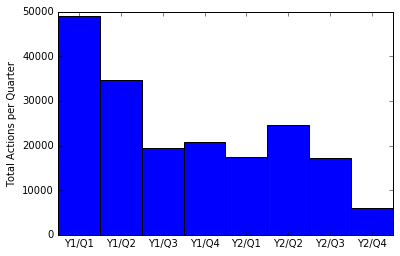

In [7]:
totalDocsPerQuarter = []
for i in range(0,8):
    totalDocsPerQuarter.append(len(docsFrame[docsFrame['Quarter']==i]))
print(totalDocsPerQuarter) 
N = len(totalDocsPerQuarter)
xvalues = numpy.arange(N)
xlabels = ['Y1/Q1', 'Y1/Q2', 'Y1/Q3', 'Y1/Q4', 'Y2/Q1', 'Y2/Q2', 'Y2/Q3', 'Y2/Q4']
plt.bar(xvalues, totalDocsPerQuarter, width=1.0)
plt.ylabel('Total Actions per Quarter')
plt.xticks(xvalues+0.5, xlabels)
plt.show()

### Plot Topics Over Time

Here we show how to aggregate the total amount of activity for any topic within each annual quarter over the entire span of the data from 1983 until 2016.

In [8]:
# Load the topic distributions for all documents from file
ldaDocTopicProbsFile = "../Data/CongressionalDocTopicProbs.npy"
docTopicProbs = numpy.load(ldaDocTopicProbsFile)
docTopicProbs.shape

(189088, 200)

In [9]:
# Aggregate the topic contributions for each document into topic bins for each quarter
numQuarters = maxSessionQuarterIndex + 1;
numTopics = docTopicProbs.shape[1]
numDocs = len(docsFrame)
topicQuarterRawCounts = numpy.zeros((numTopics,numQuarters)) 
for docIndex in range(0,numDocs):
    quarter = docsFrame['SessionQuarterIndex'][docIndex]
    for topicID in range(0,numTopics):
        topicQuarterRawCounts[topicID,quarter] += docTopicProbs[docIndex,topicID]

In [10]:
# Create label set which marks only the first quarter of each year with the year label
sessionQuarterLabels = []
for i in range(0,numQuarters):
    if ( i % 4 ) == 0:
        year = (i/4) + 1983
        sessionQuarterLabels.append(str(year))
    else:
        sessionQuarterLabels.append("")
        
print (sessionQuarterLabels)        

['1983', '', '', '', '1984', '', '', '', '1985', '', '', '', '1986', '', '', '', '1987', '', '', '', '1988', '', '', '', '1989', '', '', '', '1990', '', '', '', '1991', '', '', '', '1992', '', '', '', '1993', '', '', '', '1994', '', '', '', '1995', '', '', '', '1996', '', '', '', '1997', '', '', '', '1998', '', '', '', '1999', '', '', '', '2000', '', '', '', '2001', '', '', '', '2002', '', '', '', '2003', '', '', '', '2004', '', '', '', '2005', '', '', '', '2006', '', '', '', '2007', '', '', '', '2008', '', '', '', '2009', '', '', '', '2010', '', '', '', '2011', '', '', '', '2012', '', '', '', '2013', '', '', '', '2014', '', '', '', '2015', '', '', '', '2016']


In [11]:
# Load the text topic summaries for each of the 200 topics learned in Part 3 of the tutorial.
ldaTopicSummariesFile = "../Data/CongressionalDocTopicSummaries.tsv"
topicSummaries = pandas.read_csv(ldaTopicSummariesFile, sep='\t')
print(topicSummaries['TopicSummary'][0])
print(topicSummaries['TopicSummary'][1])

apply, terminate, open, Museum, withdrawal, forces, long, secure, cause, Afghanistan
regard, minor, Postal Service, United States for permanent, lawfully admitted


In [12]:
# Set the default figure size to be 15 in by 5 in
from pylab import rcParams
rcParams['figure.figsize'] = 15,5

# Create a function for plotting a topic over time
def PlotTopic(topicID,topicQuarterRawCounts,sessionQuarterLabels,topicSummaries):
    xlabels = sessionQuarterLabels
    xvalues = numpy.arange(len(sessionQuarterLabels))
    yvalues = topicQuarterRawCounts[topicID]
    
    plt.bar(xvalues, yvalues, width=1.0)
    plt.title(topicSummaries['TopicSummary'][topicID])
    plt.ylabel('Total Actions per Quarter')
    plt.xticks(xvalues+0.75, xlabels, rotation=90)
    plt.show()

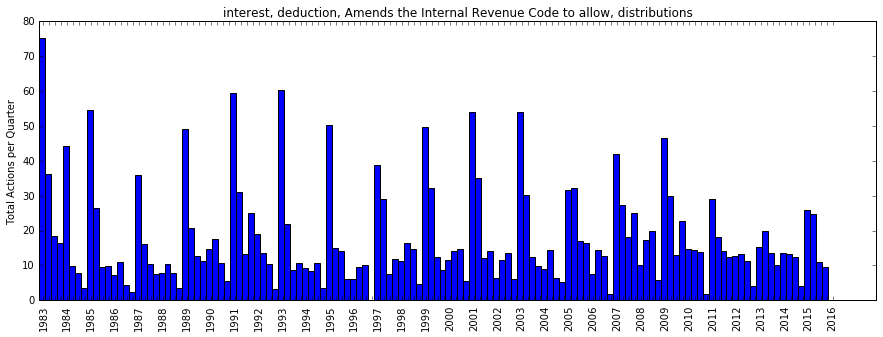

In [13]:
# Plot topic 135 (which was the second highest ranked topic identified in Part3)
PlotTopic(135,topicQuarterRawCounts,sessionQuarterLabels,topicSummaries)

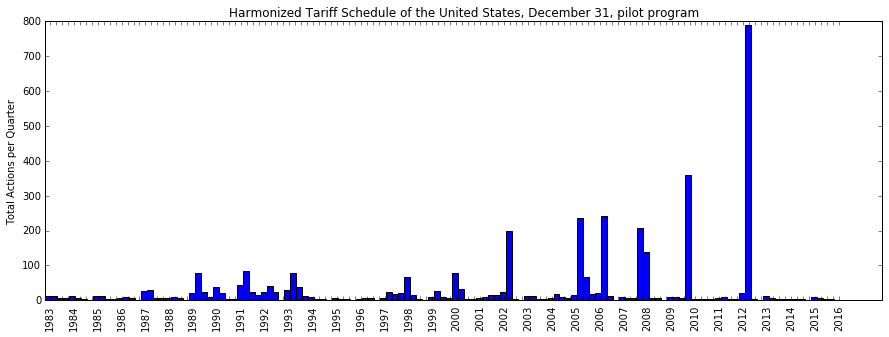

In [14]:
# Show a plot of topic 180 which was identified as the highest ranked topic in Part 3.
PlotTopic(180,topicQuarterRawCounts,sessionQuarterLabels,topicSummaries)

In [15]:
topicQuarterRawCounts[181]

array([ 40.65344778,  23.01478972,  13.87359637,  12.15709361,
        16.11307712,  16.17573397,   9.001434  ,   3.81315462,
        32.24012845,  25.7076677 ,  12.82398132,  13.96610829,
        12.14543631,  17.17703877,  14.69111419,   4.30367724,
        40.4706733 ,  21.96282195,  11.10277469,  12.1088397 ,
        10.18413222,  13.16482884,  11.86220019,   4.31055518,
        31.88608276,  19.85184504,  14.12480449,   8.83787693,
        11.19900316,  17.07819783,  12.20881446,   6.0084002 ,
        30.70858704,  22.8608985 ,  14.57617937,  16.75701301,
        11.10306495,  15.76706616,  11.84902155,   4.36157356,
        28.2549036 ,  15.04622031,  10.82427392,  12.07677299,
         7.92555428,  13.53486099,   9.57817633,   3.6087974 ,
        26.64430827,  11.57346637,   9.26496638,   8.90569408,
         5.84360001,  10.73037593,  10.88773319,   0.67650486,
        23.97764686,  17.34150175,   8.47718064,   9.650517  ,
         9.87229186,  11.75148241,   8.51324731,   4.55